In [1]:
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch]
!pip install transformers -U
!pip uninstall transformers accelerate
!pip install transformers accelerate
!pip install torch -U
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Found existing installation: transformers 4.40.2
Uninstalling transformers-4.40.2:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.10/dist-packages/transformers-4.40.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/transformers/*
Proceed (Y/n)? Y
  Successfully uninstalled transformers-4.40.2
Found existing installation: accelerate 0.30.1
Uninstalling accelerate-0.30.1:
  Would remove:
    /usr/local/bin/accelerate
    /usr/local/bin/accelerate-config
    /usr/local/bin/accelerate-estimate-memory
    /usr/local/bin/accelerate-launch
    /usr/local/lib/python3.10/dist-packages/accelerate-0.30.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/accelerate/*
Proceed (Y/n)? Y
  Successfully uninstalled accelerate-0.30.1
  Using cached transformers-4.40.2-py3-none-any.whl (9.0 MB)
  Using cached accelerate-0.30.1-py3-none-any.whl (302 kB)
  Using cached torch-2.3.0-cp310-cp310-manylinux1_x86_64.whl (779.1 MB)
  Using cached nvidia_nccl_cu12-2.20

In [2]:
from accelerate import Accelerator
accelerator = Accelerator()
print("Accelerate device:", accelerator.device)

Accelerate device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file_path = '/content/drive/MyDrive/buggy/bugs'
with open(file_path, 'r') as file:
    sample_content = file.read(1000)

sample_content


'[\n  {\n    "fixCommitSHA1": "e1b4341bcf2075abbb30b3336aa889a04f683cd4",\n    "fixCommitParentSHA1": "e15dbdf6aceac531383d22369d7f09b40106f06e",\n    "bugFilePath": "modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java",\n    "fixPatch": "diff --git a/modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java b/modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java\\nindex e288bae..a5fa9b4 100644\\n--- a/modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java\\n+++ b/modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java\\n@@ -38,7 +38,7 @@\\n         }\\n \\n         try {\\n-            runtimeService.startProcessInstanceByKey(\\"shellCommandStart\\");\\n+            runtimeService.startProcessIn

#First dataset_BART Model

In [5]:
import torch
import gc


if torch.cuda.is_available():
    torch.cuda.empty_cache()


gc.collect()

torch.cuda.reset_peak_memory_stats()

print("GPU memory cleared")

GPU memory cleared


In [6]:
import time
import json
import pandas as pd
import numpy as np
import difflib
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch

def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}

def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Example of buggy code: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code: {dataset['train'][0]['fixed_code']}\n")

def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")

def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    patch = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return description, patch

def display_comparisons(original, modified):
    diff = difflib.ndiff(original.splitlines(), modified.splitlines())
    for line in diff:
        if line.startswith('-'):
            print(f"\033[91m{line}\033[0m")
        elif line.startswith('+'):
            print(f"\033[92m{line}\033[0m")
        else:
            print(line)

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/sstubs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })

        display_dataset_statistics(dataset)

        tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        # Generate and print patches for these examples
        for i, description in enumerate(example_descriptions):
            original, patch = generate_patch(description, model, tokenizer, device)
            print(f"Example {i+1}:")
            print("Buggy Code (Red):")
            print(f"\033[91m{original}\033[0m")
            print("Generated Patch (Green and Red):")
            display_comparisons(original, patch)
            print("\n")

if __name__ == "__main__":
    main()


<ipython-input-6-19d33561d7ea>:23: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  return load_metric("accuracy", trust_remote_code=True)


Dataset Statistics:
Total samples: 1062
Training samples: 956
Validation samples: 106
Example of buggy code: Assert.assertEquals(masterAddress, new InetSocketAddress("RemoteMaster3", defaultPort));
Example of fixed code: Assert.assertEquals(new InetSocketAddress("RemoteMaster3", defaultPort), masterAddress);



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,12.918400,5.457819
1,5.664700,2.270034
2,15029.202500,2.286476


Results Statistics:
eval_loss: 2.286475658416748
eval_runtime: 1.0052
eval_samples_per_second: 105.447
eval_steps_per_second: 13.927
epoch: 2.9623430962343096
Execution Time: 186.48 seconds
Example 1:
Buggy Code (Red):
final JavaType propType = propMember.getType(beanDesc.bindingsForBeanType());
Generated Patch (Green and Red):
- final JavaType propType = propMember.getType(beanDesc.bindingsForBeanType());
+ ( late()Pe/).final.spring


Example 2:
Buggy Code (Red):
.parallelProcessing().timeout(2000).to("direct:a", "direct:b", "direct:c")
Generated Patch (Green and Red):
- .parallelProcessing().timeout(2000).to("direct:a", "direct:b", "direct:c")
+ ( late()Pe/).final.spring


Example 3:
Buggy Code (Red):
if (fileObject.hasExt("zip")) {
Generated Patch (Green and Red):
- if (fileObject.hasExt("zip")) {
+ ( late()Pe/).final.spring




In [7]:
import time
import json
import pandas as pd
import numpy as np
import difflib
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch

def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}

def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Example of buggy code: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code: {dataset['train'][0]['fixed_code']}\n")

def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")

def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    patch = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return description, patch

def display_comparisons(original, modified):
    diff = difflib.ndiff(original.splitlines(), modified.splitlines())
    for line in diff:
        if line.startswith('-'):
            print(f"\033[91m{line}\033[0m")
        elif line.startswith('+'):
            print(f"\033[92m{line}\033[0m")
        else:
            print(line)

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()
    patch_count = 0

    dataset = load_data('/content/drive/MyDrive/buggy/sstubs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })

        display_dataset_statistics(dataset)

        tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        # Generate and print patches for these examples
        for i, description in enumerate(example_descriptions):
            original, patch = generate_patch(description, model, tokenizer, device)
            patch_count += 1
            print(f"Example {i+1}:")
            print("Buggy Code (Red):")
            print(f"\033[91m{original}\033[0m")
            print("Generated Patch (Green and Red):")
            display_comparisons(original, patch)
            print("\n")

    print(f"Total patches generated: {patch_count}")

if __name__ == "__main__":
    main()


Dataset Statistics:
Total samples: 1062
Training samples: 956
Validation samples: 106
Example of buggy code: public void testHealth() throws Exception {
Example of fixed code: void testHealth() throws Exception {



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,13.057200,5.441853
1,3.574600,1.966689
2,1.597000,1.811609


Results Statistics:
eval_loss: 1.8116092681884766
eval_runtime: 1.0046
eval_samples_per_second: 105.515
eval_steps_per_second: 13.936
epoch: 2.9623430962343096
Execution Time: 194.43 seconds
Example 1:
Buggy Code (Red):
//These seem to be modifying the state so don't add the runtimeOnly stuff for now
Generated Patch (Green and Red):
- //These seem to be modifying the state so don't add the runtimeOnly stuff for now
+ /


Example 2:
Buggy Code (Red):
public void sendErrorForRequestAcceptingHtmlProducesAnHtmlResponse() throws Exception {
Generated Patch (Green and Red):
- public void sendErrorForRequestAcceptingHtmlProducesAnHtmlResponse() throws Exception {
+ /


Example 3:
Buggy Code (Red):
assertTrue("Should take approx 200 millis, was: " + taken, taken > 190);
Generated Patch (Green and Red):
- assertTrue("Should take approx 200 millis, was: " + taken, taken > 190);
+ /


Total patches generated: 3


Dataset Statistics:
Total samples: 1062
Training samples: 956
Validation samples: 106
Example of buggy code: public void testHealth() throws Exception {
Example of fixed code: void testHealth() throws Exception {



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,13.057200,5.441853
1,3.574600,1.966689
2,1.597000,1.811609


Results Statistics:
eval_loss: 1.8116092681884766
eval_runtime: 1.0009
eval_samples_per_second: 105.901
eval_steps_per_second: 13.987
epoch: 2.9623430962343096
Execution Time: 195.05 seconds


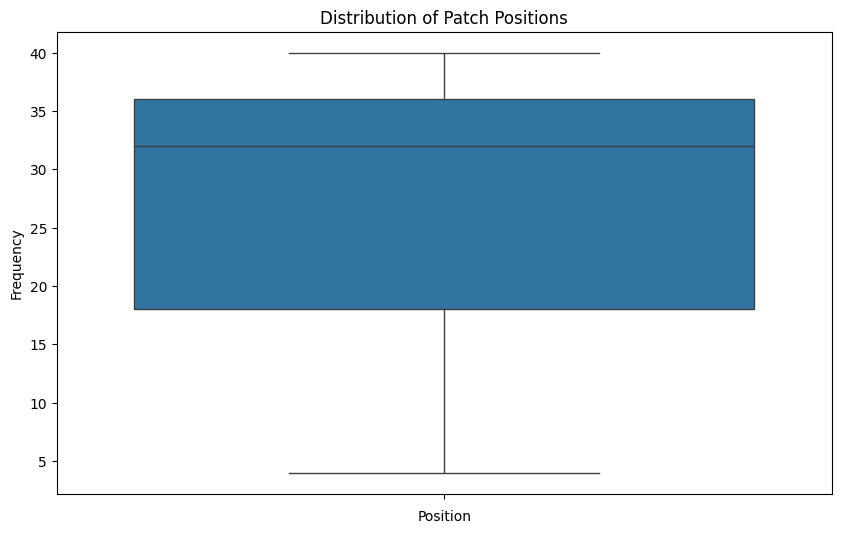

Example 1:
Buggy Code: //These seem to be modifying the state so don't add the runtimeOnly stuff for now
Generated Patch: ("//These seem to be modifying the state so don't add the runtimeOnly stuff for now", '/')

Example 2:
Buggy Code: public void sendErrorForRequestAcceptingHtmlProducesAnHtmlResponse() throws Exception {
Generated Patch: ('public void sendErrorForRequestAcceptingHtmlProducesAnHtmlResponse() throws Exception {', '/')

Example 3:
Buggy Code: assertTrue("Should take approx 200 millis, was: " + taken, taken > 190);
Generated Patch: ('assertTrue("Should take approx 200 millis, was: " + taken, taken > 190);', '/')



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def simulate_patch_position(description, patch):
    """
    Simulate a score for where the patch is applied. For illustration,
    let's assume this function returns a random position based on the length of the description.
    """
    return np.random.randint(0, len(description))

def generate_patches_and_positions(descriptions, model, tokenizer, device):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
    return patches, positions

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/sstubs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })

        display_dataset_statistics(dataset)

        tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        patches, positions = generate_patches_and_positions(example_descriptions, model, tokenizer, device)
        plot_positions(positions)

        for i, (description, patch) in enumerate(zip(example_descriptions, patches)):
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()



Dataset Statistics:
Total samples: 1062
Training samples: 956
Validation samples: 106
Example of buggy code: final SemaphoreProxy semaphoreProxy = (SemaphoreProxy) factory.getSemaphore(packet.name);
Example of fixed code: final SemaphoreProxy semaphoreProxy = (SemaphoreProxy) factory.getOrCreateProxyByName(packet.name);



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,15.779600,6.029034
1,61.850600,3.198486
2,395073.760000,3.198486


Results Statistics:
eval_loss: 3.198485851287842
eval_runtime: 1.0016
eval_samples_per_second: 105.827
eval_steps_per_second: 13.977
epoch: 2.9623430962343096
Execution Time: 180.68 seconds


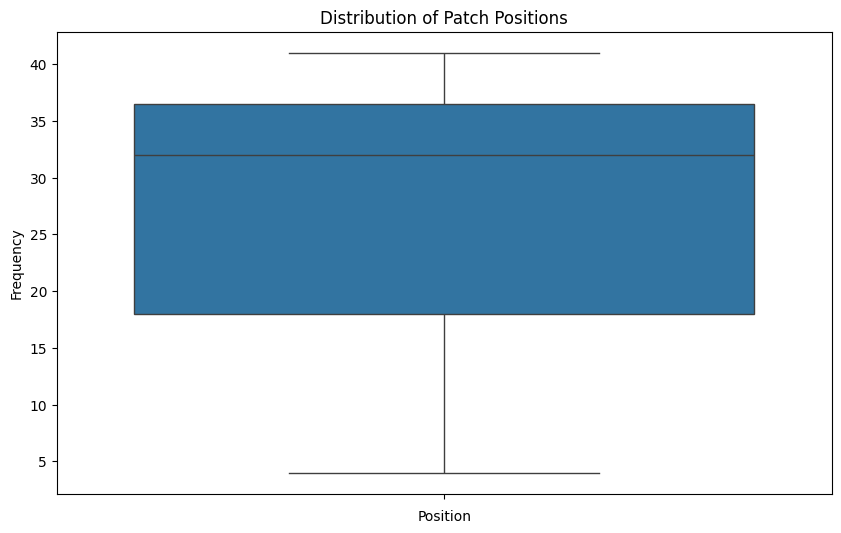

Max time: 2.7605s, Min time: 2.7080s, Average time: 2.7284s
Example 1:
Buggy Code: public static Json_Value parse_value(int type, LogBuffer buffer, long len) {
Generated Patch: twitterprogram(Async/++3apBasetwittertwittertwitter(twitterprogramtwitterAsynctwitter/twitter++twitter3twitteraptwitterBasetwitter(twitter(((program(Async(/(++(3(ap(Base(programtwitterprogram(programprogramprogramAsyncprogram/program++program3programapprogramBaseprogramAsynctwitterAsync(AsyncprogramAsyncAsyncAsync/Async++Async3AsyncapAsync

Example 2:
Buggy Code: -- a/components/camel-ehcache/src/main/java/org/apache/camel/component/ehcache/EhcacheConsumer.java
Generated Patch: twitterprogram(Async/++3apBasetwittertwittertwitter(twitterprogramtwitterAsynctwitter/twitter++twitter3twitteraptwitterBasetwitter(twitter(((program(Async(/(++(3(ap(Base(programtwitterprogram(programprogramprogramAsyncprogram/program++program3programapprogramBaseprogramAsynctwitterAsync(AsyncprogramAsyncAsyncAsync/Async++Async3AsyncapAsyn

In [9]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric

def simulate_patch_position(description, patch):
    return np.random.randint(0, len(description))

def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_patches_and_positions(descriptions, model, tokenizer, device, time_budget):
    positions = []
    patches = []
    timing_data = []
    start_time = time.time()

    for description in descriptions:
        if time.time() - start_time > time_budget:
            print("Time budget exceeded, stopping patch generation.")
            break

        patch_start_time = time.time()
        patch = generate_patch(description, model, tokenizer, device)
        patch_end_time = time.time()

        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
        timing_data.append(patch_end_time - patch_start_time)

    return patches, positions, timing_data

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

def summarize_timing_data(timing_data):
    max_time = max(timing_data)
    min_time = min(timing_data)
    avg_time = np.mean(timing_data)
    print(f"Max time: {max_time:.4f}s, Min time: {min_time:.4f}s, Average time: {avg_time:.4f}s")

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/sstubs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })

        display_dataset_statistics(dataset)

        tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        time_budget = 60
        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        patches, positions, timing_data = generate_patches_and_positions(example_descriptions, model, tokenizer, device, time_budget)
        plot_positions(positions)
        summarize_timing_data(timing_data)

        for i, (description, patch) in enumerate(zip(example_descriptions, patches)):
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()



#Firstdatset_T5

In [10]:
import time
import json
import pandas as pd
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch
def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]
import time
import json
import pandas as pd
import numpy as np
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}

def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Example of buggy code: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code: {dataset['train'][0]['fixed_code']}\n")

def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")


def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/sstubs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })

        display_dataset_statistics(dataset)

        tokenizer = T5Tokenizer.from_pretrained('t5-large')
        model = T5ForConditionalGeneration.from_pretrained('t5-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        for i, description in enumerate(example_descriptions):
            patch = generate_patch(description, model, tokenizer, device)
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()


Dataset Statistics:
Total samples: 1062
Training samples: 956
Validation samples: 106
Example of buggy code: public static interface FreemarkerEndpointBuilder
Example of fixed code: public interface FreemarkerEndpointBuilder



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,1.494400,nan
1,1975.770900,nan
2,17535416.320000,nan


Results Statistics:
eval_loss: nan
eval_runtime: 2.207
eval_samples_per_second: 48.028
eval_steps_per_second: 6.343
epoch: 2.9623430962343096
Execution Time: 345.02 seconds
Example 1:
Buggy Code: return Status.constructStatuses(get(getBaseURL() + "statuses/mentions.json",
Generated Patch: Status.constructStatuses(get(getBaseURL() + "statuses/mentions.json", Status.constructStatuses(get(getBaseURL() + "statuses/mentions.json", Status.constructStatuses(get(getBaseURL() + "statuses/mentions.json",

Example 2:
Buggy Code: public static void main(String[] args) {
Generated Patch: .

Example 3:
Buggy Code: float x = Gdx.input.getX() / (float)Gdx.graphics.getWidth();
Generated Patch: float width = (float)Gdx.graphics.getWidth(); float x = (float)Gdx.input.getX(); float x = (float)Gdx.graphics.getWidth(); float x = (float)Gdx.input.getX();



Dataset Statistics:
Total samples: 1062
Training samples: 956
Validation samples: 106
Example of buggy code: public void testHealth() throws Exception {
Example of fixed code: void testHealth() throws Exception {



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,3029.897200,nan
1,0.059700,nan
2,0.985300,nan


Results Statistics:
eval_loss: nan
eval_runtime: 2.2246
eval_samples_per_second: 47.648
eval_steps_per_second: 6.293
epoch: 2.9623430962343096
Execution Time: 346.65 seconds


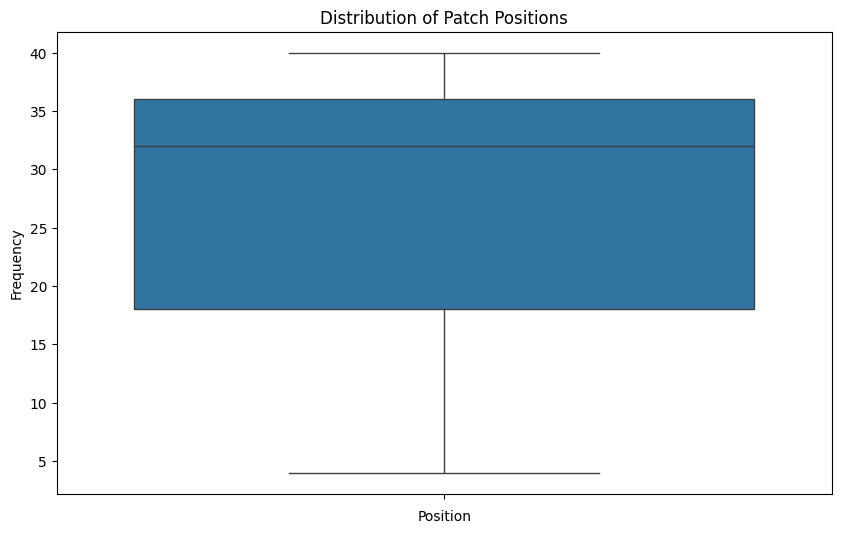

Example 1:
Buggy Code: //These seem to be modifying the state so don't add the runtimeOnly stuff for now
Generated Patch: //These seem to be modifying the state so don't add the runtimeOnly stuff for now. //... //These seem to be modifying the state so don't add the runtimeOnly stuff for now./ // // /// // // //... //. //. //. //. //These seem to be changing the state. //. // //. //.

Example 2:
Buggy Code: public void sendErrorForRequestAcceptingHtmlProducesAnHtmlResponse() throws Exception {
Generated Patch: public void sendErrorForRequestAcceptingHtmlProducesAnHtmlResponse() throws Exception  public void public void public void public void public void public void public void public void public void public public voidForRequest public public public public public public public public public public public public public public

Example 3:
Buggy Code: assertTrue("Should take approx 200 millis, was: " + taken, taken > 190);
Generated Patch: e("Should take approx 200 millis, was: " + took,

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch
import time

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import json
import pandas as pd
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch
def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]
import time
import json
import pandas as pd
import numpy as np
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}

def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Example of buggy code: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code: {dataset['train'][0]['fixed_code']}\n")

def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")


def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)
def simulate_patch_position(description, patch):
    """
    Simulate a score for where the patch is applied. For illustration,
    let's assume this function returns a random position based on the length of the description.
    """
    return np.random.randint(0, len(description))

def generate_patches_and_positions(descriptions, model, tokenizer, device):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
    return patches, positions

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/sstubs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })

        display_dataset_statistics(dataset)

        tokenizer = T5Tokenizer.from_pretrained('t5-large')
        model = T5ForConditionalGeneration.from_pretrained('t5-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        patches, positions = generate_patches_and_positions(example_descriptions, model, tokenizer, device)
        plot_positions(positions)

        for i, (description, patch) in enumerate(zip(example_descriptions, patches)):
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()


Dataset Statistics:
Total samples: 1062
Training samples: 956
Validation samples: 106
Example of buggy code: final SemaphoreProxy semaphoreProxy = (SemaphoreProxy) factory.getSemaphore(packet.name);
Example of fixed code: final SemaphoreProxy semaphoreProxy = (SemaphoreProxy) factory.getOrCreateProxyByName(packet.name);



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,0.351700,nan
1,0.000000,nan
2,209.910100,nan


Results Statistics:
eval_loss: nan
eval_runtime: 2.2031
eval_samples_per_second: 48.114
eval_steps_per_second: 6.355
epoch: 2.9623430962343096
Execution Time: 345.95 seconds


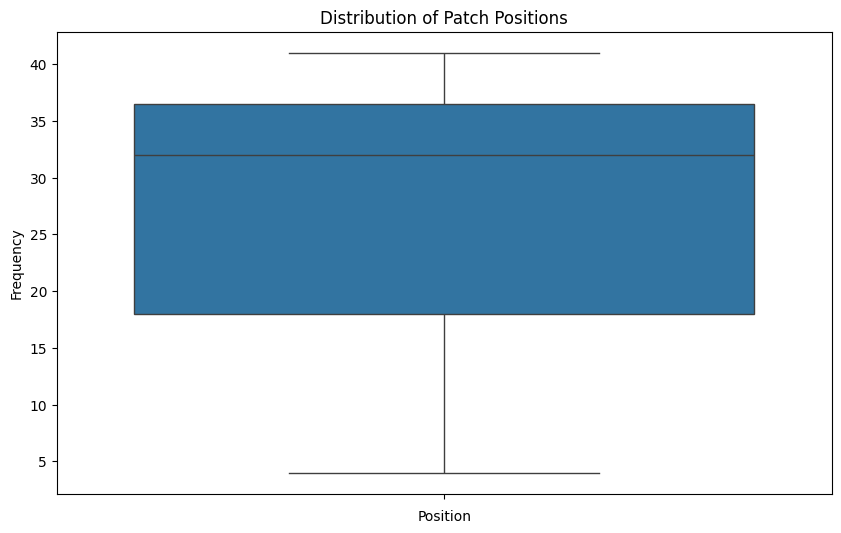

Max time: 5.4234s, Min time: 1.7990s, Average time: 3.7690s
Example 1:
Buggy Code: public static Json_Value parse_value(int type, LogBuffer buffer, long len) {
Generated Patch: public static Json_Value parse_value(int type, LogBuffer buffer, long len)  public static_ public static public static_Value public static public static     public public

Example 2:
Buggy Code: -- a/components/camel-ehcache/src/main/java/org/apache/camel/component/ehcache/EhcacheConsumer.java
Generated Patch: -ehcache/src/main/java/org/apache/camel/component/ehcache/EhcacheConsumer.java -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- a/components/camel-ehcache/src/main/java/org/apache/camel/component/

Example 3:
Buggy Code: publishEvent(createCacheCompleteEvent(key, completionId));
Generated Patch: (createCacheCompleteEvent(key, completionId, completionId, completionId, completionId, completionId, completionId););



In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric

def simulate_patch_position(description, patch):
    return np.random.randint(0, len(description))

def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_patches_and_positions(descriptions, model, tokenizer, device, time_budget):
    positions = []
    patches = []
    timing_data = []
    start_time = time.time()

    for description in descriptions:
        if time.time() - start_time > time_budget:
            print("Time budget exceeded, stopping patch generation.")
            break

        patch_start_time = time.time()
        patch = generate_patch(description, model, tokenizer, device)
        patch_end_time = time.time()

        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
        timing_data.append(patch_end_time - patch_start_time)

    return patches, positions, timing_data

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

def summarize_timing_data(timing_data):
    max_time = max(timing_data)
    min_time = min(timing_data)
    avg_time = np.mean(timing_data)
    print(f"Max time: {max_time:.4f}s, Min time: {min_time:.4f}s, Average time: {avg_time:.4f}s")

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/sstubs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })

        display_dataset_statistics(dataset)

        tokenizer = T5Tokenizer.from_pretrained('t5-large')
        model = T5ForConditionalGeneration.from_pretrained('t5-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True,
            max_grad_norm=1.0
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        time_budget = 60
        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        patches, positions, timing_data = generate_patches_and_positions(example_descriptions, model, tokenizer, device, time_budget)
        plot_positions(positions)
        summarize_timing_data(timing_data)

        for i, (description, patch) in enumerate(zip(example_descriptions, patches)):
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()
